In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from cloudvolume import CloudVolume, view
import napari
%gui qt

C:\Users\Sanika\Anaconda3\envs\mouselight\lib\site-packages\python_jsonschema_objects\__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(
C:\Users\Sanika\Anaconda3\envs\mouselight\lib\site-packages\qtpy\__init__.py:215: RuntimeWarning: Selected binding "pyqt5" could not be found, using "pyside2"
  warnings.warn('Selected binding "{}" could not be found, '


In [2]:
cv = CloudVolume(
        'https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1',
        progress=True,
        mip = 0,
        cache=False,
        parallel=True,
    )

In [3]:
def scale(verts):
    scales = cv.scales[1]['resolution']
    scaled = verts/scales
    int_scaled = [int(i) for i in scaled]
    return np.array(int_scaled).reshape(-1,1)

def up_to_img(seg_id, v_id):
    SEGID=seg_id
    cv_skel = CloudVolume(
        'https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1_segments',
        mip = 0,
        cache=False,
        parallel=False,
    )
    skel = cv_skel.skeleton.get(SEGID) 
    
    img = cv.download_point( scale(skel.vertices[v_id]), 
                        mip=1, size=(100,100,100),
                        coord_resolution=cv.scales[1]['resolution'])
    
    return img, cv

In [4]:
img, cv = up_to_img(2, 199)
#print (img)

Downloading: 100%|███████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


In [5]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1]*2
    ysize = nda.shape[0]*2

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if(title):
        plt.title(title)

    plt.show()

def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05,
             dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))


    img_null = sitk.Image([0, 0], img.GetPixelID(),
                          img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i)
                                for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)

In [6]:
def img_to_labels(img, low=28, up=255):
    img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
    img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
    seed = (50,50,50)
    seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
    seg.CopyInformation(img_T1)
    seg[seed] = 1
    seg = sitk.BinaryDilate(seg, 1)
    seg_con = sitk.ConnectedThreshold(img_T1_255, seedList=[seed],
                                      lower=low, upper=up)
    vectorRadius = (1, 1, 1)
    kernel = sitk.sitkBall
    seg_clean = sitk.BinaryMorphologicalClosing(seg_con,
                                                vectorRadius,
                                                kernel)
    myshow3d(sitk.LabelOverlay(img_T1_255, seg_clean),
         zslices=range(48,53), title="Closed Connected Threshold")
    labels = sitk.GetArrayFromImage(seg_clean)
    return labels

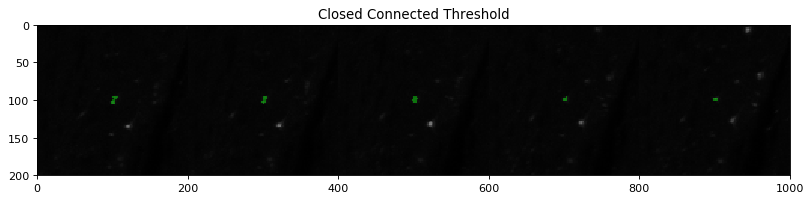

In [7]:
#myshow(img, None, 0.05, 80)
labels = img_to_labels(img, 20) #100:10, 200:25, 400:10

In [9]:
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='segmentation')

<Labels layer 'segmentation' at 0x1b328c116a0>